# Curriculum Learning for Image Classification
### Prepared by: Christian Tia

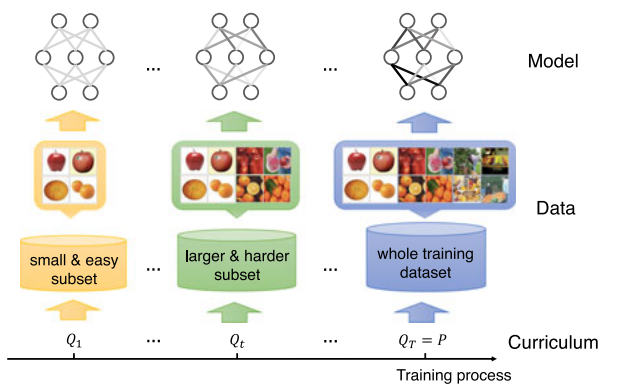

# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## ResNet-18 Model

The ResNet-18 model (without pretraining) will be used for all learning models demonstrated in this notebook.

In [2]:
def create_model():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(512, 10)
    return model.to(device)

## CIFAR-10-C Dataset

Derived from the original CIFAR-10 test set (10,000 images)

CIFAR-10-C Dataset consists of the same 10,000 images corrupted to different severity levels.
* `0-9999` : Test set images corrupted at severity 1
* `10,000-19,999` : Test set images corrupted at severity 2
* `20,000-29,999` : Test set images corrupted at severity 3
* `30,000-39,999` : Test set images corrupted at severity 4
* `40,000-49,999` : Test set images corrupted at severity 5

Different corruption methods are available to use:
1. Gaussian Noise
2. Motion Blur
3. JPEG compression
4. Etc.

https://zenodo.org/records/2535967

The following code displays an example image at 5 different severity levels:

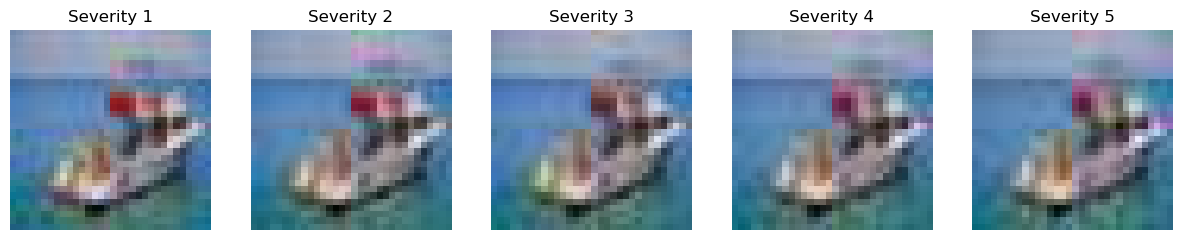

In [59]:
corruption = "jpeg_compression"
root = "C:/Users/ASUS/.data/CIFAR-10-C"

data = np.load(f"{root}/{corruption}.npy")
labels = np.load(f"{root}/labels.npy")

example = 8888

indices = [example + 10000 * s for s in range(5)]

fig, axs = plt.subplots(1, 5, figsize=(15,3))

for j, idx in enumerate(indices):
    img = data[idx]
    img = img.astype(np.float32) / 255.0
    label = labels[idx]

    axs[j].imshow(img)
    axs[j].set_title(f"Severity {j+1}")
    axs[j].axis("off")

plt.show()

In order to simulate a real-world "noisy" dataset, the following function can be used to generate `n` random severity levels using a modified normal distribution.

In [4]:
def sample_severities(n, center=1.0, scale=1.0, tail_factor=1.5):
    base = np.random.normal(loc=center, scale=scale, size=n)

    base = base * tail_factor

    base = np.clip(base, 1, 5)

    sev = np.rint(base).astype(int)
    return sev

The 10,000 available images will be split into train (80%), test (10%), and validation (10%) sets. The `sample_severities` function is used to generate severity distributions for each. Notice that the `tail_factor` of the `train_severities` is larger than the others. This is to simulate a training set that is noisier than real-world use cases.

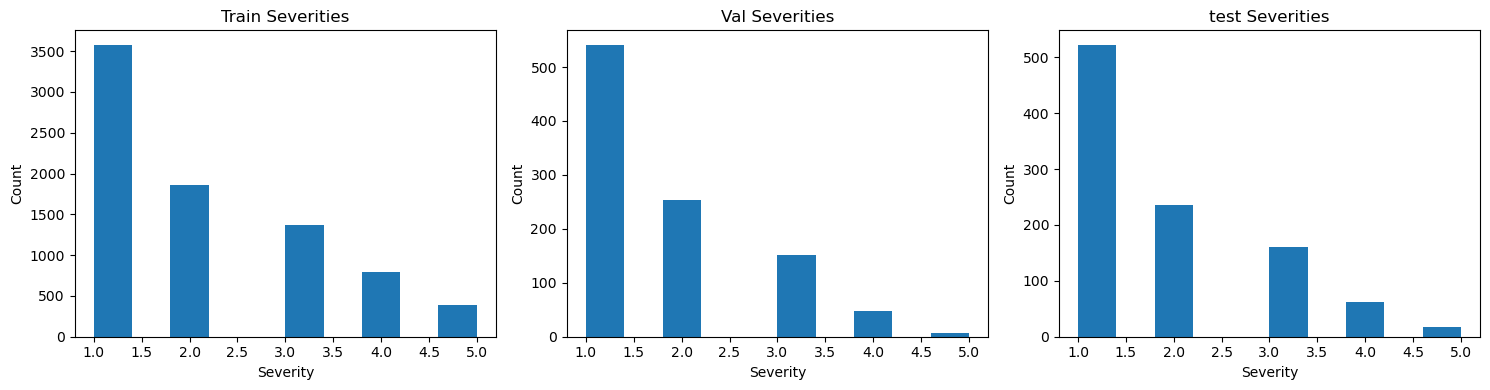

In [5]:
train_severities = sample_severities(8000, tail_factor=1.7)
test_severities = sample_severities(1000, tail_factor=1.4)
val_severities = sample_severities(1000, tail_factor=1.4)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(train_severities)
axes[0].set_title("Train Severities")
axes[0].set_xlabel("Severity")
axes[0].set_ylabel("Count")

axes[1].hist(val_severities)
axes[1].set_title("Val Severities")
axes[1].set_xlabel("Severity")
axes[1].set_ylabel("Count")

axes[2].hist(test_severities)
axes[2].set_title("test Severities")
axes[2].set_xlabel("Severity")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Even though a single `.npy` file contains 50,000 images, only 10,000 of these are truly unique since the rest are corrupted duplicates. The following class is a custom PyTorch Dataset that allows us to pair each of these unique images (0,9999) to a single corruption severity level (1,5). The end result is a datset consisting of 10,000 images, all unique, with severity levels that follow the distribution defined above using `sample_severity`.

In [6]:
class CIFAR10C(torch.utils.data.Dataset):
    def __init__(self, severities, indices, root="C:/Users/ASUS/.data/CIFAR-10-C", corruption="jpeg_compression", transform=None):

        self.data = np.load(f"{root}/{corruption}.npy")
        self.labels = np.load(f"{root}/labels.npy")
        self.severities = severities
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):

        original_index = self.indices[i]
        severity = self.severities[i]

        index = (severity - 1) * 10000 + original_index

        img = self.data[index]
        img = img.astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        label = self.labels[original_index]

        return img, label, severity

The `train_test_split` function is used to randomly split the 10,000 indices into train, validation, and test sets.

In [7]:
orig_indices = np.arange(10000)

train_indices, test_indices = train_test_split(
    orig_indices,
    test_size=0.2,
    random_state=42,
)

val_indices, test_indices = train_test_split(
    test_indices,
    test_size=0.5,
    random_state=42,
)

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_set = CIFAR10C(train_severities, train_indices, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

test_set = CIFAR10C(test_severities, test_indices, transform=transform)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

val_set = CIFAR10C(val_severities, val_indices, transform=transform)
val_loader  = DataLoader(val_set, batch_size=128, shuffle=False)

#### Sanity Check

The following function shows how labels and severities are distributed per dataset. Labels must be roughly equal, while severities must follow the distribution defined above.

In [9]:
def check_loader_distribution(loader, name):
    labels = []
    severities = []
    
    for x, y, s in loader:
        labels.extend(y.tolist())
        severities.extend(s.tolist())
    
    print(f"\nDistribution in {name}")
    print("\tLabel distribution:")
    print(f"\t{dict(sorted(Counter(labels).items()))}")

    print("\tSeverity distribution:")
    print(f"\t{dict(sorted(Counter(severities).items()))}")

check_loader_distribution(train_loader, "Train Loader")
check_loader_distribution(test_loader, "Test Loader")
check_loader_distribution(val_loader, "Test Loader")


Distribution in Train Loader
	Label distribution:
	{0: 813, 1: 811, 2: 799, 3: 802, 4: 819, 5: 809, 6: 787, 7: 774, 8: 797, 9: 789}
	Severity distribution:
	{1: 3577, 2: 1865, 3: 1369, 4: 797, 5: 392}

Distribution in Test Loader
	Label distribution:
	{0: 93, 1: 96, 2: 92, 3: 98, 4: 102, 5: 95, 6: 104, 7: 116, 8: 103, 9: 101}
	Severity distribution:
	{1: 522, 2: 236, 3: 161, 4: 63, 5: 18}

Distribution in Test Loader
	Label distribution:
	{0: 94, 1: 93, 2: 109, 3: 100, 4: 79, 5: 96, 6: 109, 7: 110, 8: 100, 9: 110}
	Severity distribution:
	{1: 541, 2: 253, 3: 152, 4: 48, 5: 6}


Each model will be evaluated best on accuracy. The following function returns the accuracy of a `model` on a specified (data)`loader`.

In [10]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

# Implementing Curriculum Learning

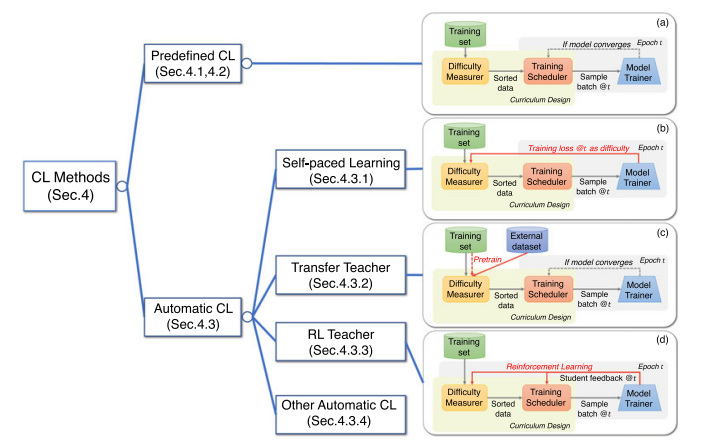

All predefined CL methods will use the following `train_model` function. It uses a specified difficulty_measurer and train_scheduler to determine which proportion of examples to use at a specific time step.

In [11]:
def train_model(difficulty_measurer=None, training_scheduler=None, name=None):
    epochs = 50
    model = create_model()
    opt = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    val_accs = []
    best_val_acc = 0.0
    best_weights = None

    print(f"[{name}]")
    for t in range(epochs):
        model.train()

        if difficulty_measurer is not None and training_scheduler is not None:
            # GET CURRICULUM 
            lam = training_scheduler(t)
            sorted_train_set = difficulty_measurer()
    
            subset_size = int(len(train_set) * lam)
            subset_indices = sorted_train_set.indices[:subset_size]
            subset_severities = sorted_train_set.severities[:subset_size]
            subset = CIFAR10C(subset_severities, subset_indices, transform=transform)
    
            data_loader = DataLoader(subset, batch_size=128, shuffle=True)

        else:
            data_loader = DataLoader(train_set, batch_size=128, shuffle=True)
        # TRAIN
        model.train()
        for x, y, _ in data_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()

        # VALIDATE
        model.eval()
        val_acc = evaluate(model, val_loader)
        val_accs.append(val_acc)
    
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = model.state_dict()

        if difficulty_measurer is not None and training_scheduler is not None:
            print(f"\tEpoch {t+1}/{epochs} | Val Acc: {val_acc:.4f} | Lambda: {lam:.2f} | Size: {len(subset)}")
        else:
            print(f"\tEpoch {t+1}/{epochs} | Val Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    
    test_acc = evaluate(model, test_loader)
    print(f"\nTest Accuracy: {test_acc}")

    return model, val_accs, test_acc
                

## Traditional Learning

To serve as a point of comparsion, we will first train a model using the traditional method.

In [12]:
traditional_model, traditional_val_accs, traditional_test_acc = train_model(name="Traditional")

[Traditional]
	Epoch 1/50 | Val Acc: 0.3940
	Epoch 2/50 | Val Acc: 0.4230
	Epoch 3/50 | Val Acc: 0.4250
	Epoch 4/50 | Val Acc: 0.4040
	Epoch 5/50 | Val Acc: 0.4300
	Epoch 6/50 | Val Acc: 0.4310
	Epoch 7/50 | Val Acc: 0.4210
	Epoch 8/50 | Val Acc: 0.4150
	Epoch 9/50 | Val Acc: 0.4220
	Epoch 10/50 | Val Acc: 0.4230
	Epoch 11/50 | Val Acc: 0.4180
	Epoch 12/50 | Val Acc: 0.4230
	Epoch 13/50 | Val Acc: 0.4060
	Epoch 14/50 | Val Acc: 0.4210
	Epoch 15/50 | Val Acc: 0.4160
	Epoch 16/50 | Val Acc: 0.4190
	Epoch 17/50 | Val Acc: 0.4190
	Epoch 18/50 | Val Acc: 0.4080
	Epoch 19/50 | Val Acc: 0.4140
	Epoch 20/50 | Val Acc: 0.4160
	Epoch 21/50 | Val Acc: 0.4180
	Epoch 22/50 | Val Acc: 0.4270
	Epoch 23/50 | Val Acc: 0.4110
	Epoch 24/50 | Val Acc: 0.4150
	Epoch 25/50 | Val Acc: 0.4180
	Epoch 26/50 | Val Acc: 0.4150
	Epoch 27/50 | Val Acc: 0.4110
	Epoch 28/50 | Val Acc: 0.4150
	Epoch 29/50 | Val Acc: 0.4120
	Epoch 30/50 | Val Acc: 0.4210
	Epoch 31/50 | Val Acc: 0.4250
	Epoch 32/50 | Val Acc: 0.3830
	Ep

## Predefined CL

Example training schedulers:
<br>
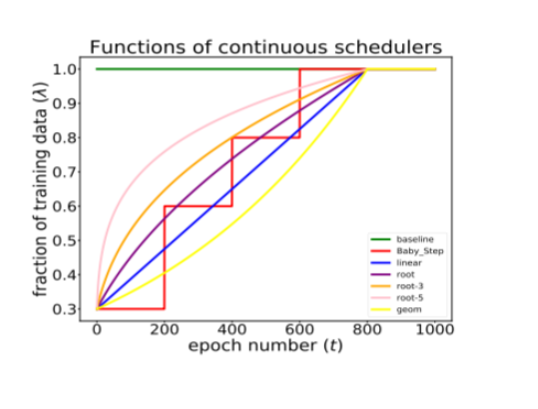

In predefined CL, we must manually design the Difficulty Measurer and Training Scheduler based on the characteristics of the dataset. We know that each image in the dataset is corrupted to a certain severity level. Thus, we will use this severity as our difficulty measure.

In [13]:
def predefined_difficulty_measurer():
    order = np.argsort(train_set.severities) # sort "virtual" indices according to severity
    
    sorted_severities = train_set.severities[order] # get the sorted severities
    sorted_indices = train_set.indices[order] # sort "physical" indices according to severity

    return CIFAR10C(sorted_severities, sorted_indices, transform=transform)

For the training scheduler, we can use the Baby Step algorithm, which adjusts the threshold every fixed number of epochs. This is known as a **discrete scheduler**.

### Using Baby Step

In [14]:
def discrete_scheduler(t):
    start_rate = 0.5
    grow_rate = 0.1
    grow_interval = 10
    
    return min(1.0, start_rate + grow_rate * ((t - 1) // grow_interval + 1))

In [15]:
babystep_model, babystep_val_accs, babystep_test_acc = train_model(difficulty_measurer=predefined_difficulty_measurer, 
                                                                   training_scheduler=discrete_scheduler, 
                                                                   name="Baby Step Predefined CL")

[Baby Step Predefined CL]
	Epoch 1/50 | Val Acc: 0.2780 | Lambda: 0.50 | Size: 4000
	Epoch 2/50 | Val Acc: 0.3720 | Lambda: 0.60 | Size: 4800
	Epoch 3/50 | Val Acc: 0.4270 | Lambda: 0.60 | Size: 4800
	Epoch 4/50 | Val Acc: 0.4140 | Lambda: 0.60 | Size: 4800
	Epoch 5/50 | Val Acc: 0.4150 | Lambda: 0.60 | Size: 4800
	Epoch 6/50 | Val Acc: 0.4200 | Lambda: 0.60 | Size: 4800
	Epoch 7/50 | Val Acc: 0.4090 | Lambda: 0.60 | Size: 4800
	Epoch 8/50 | Val Acc: 0.4310 | Lambda: 0.60 | Size: 4800
	Epoch 9/50 | Val Acc: 0.4280 | Lambda: 0.60 | Size: 4800
	Epoch 10/50 | Val Acc: 0.4240 | Lambda: 0.60 | Size: 4800
	Epoch 11/50 | Val Acc: 0.4290 | Lambda: 0.60 | Size: 4800
	Epoch 12/50 | Val Acc: 0.3900 | Lambda: 0.70 | Size: 5600
	Epoch 13/50 | Val Acc: 0.4000 | Lambda: 0.70 | Size: 5600
	Epoch 14/50 | Val Acc: 0.4220 | Lambda: 0.70 | Size: 5600
	Epoch 15/50 | Val Acc: 0.4180 | Lambda: 0.70 | Size: 5600
	Epoch 16/50 | Val Acc: 0.4240 | Lambda: 0.70 | Size: 5600
	Epoch 17/50 | Val Acc: 0.4310 | Lambda

### Using a Pacing Function

Another option is to use a **continuous scheduler**. The following functions simulate a *linear function* and *root function*, respectively.

$$ linear(t) = \min\left(1,\; 
\lambda_0 + \frac{1 - \lambda_0}{T_{\text{grow}}}\, t
\right) $$

$$ \text{root-}p(t) = \min\left( 1,\;
\left( \lambda_0^p \;+\; \frac{1 - \lambda_0^p}{T_{\text{grow}}}\, t \right)^{1/p}
\right) $$

In [16]:
def linear_lam_fn(t):
    lam_0 = 0.5
    t_grow = 40
    
    lam = lam_0 + (1.0 - lam_0) / t_grow * t
    return 1.0 if t >= t_grow else lam

def root_5_lam_fn(t):
    lam_0 = 0.5
    t_grow = 40
    p = 5      
    
    lam = (lam_0 ** p + (1.0 - lam_0 ** p) / t_grow * t) ** (1/p)        
    return 1.0 if t >= t_grow else lam

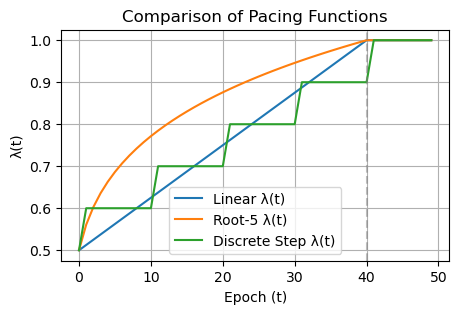

In [17]:
ts = np.arange(0, 50)
linear_vals = [linear_lam_fn(t) for t in ts]
root5_vals = [root_5_lam_fn(t) for t in ts]
discrete_vals = [discrete_scheduler(t) for t in ts]

plt.figure(figsize=(5, 3))
plt.plot(ts, linear_vals, label="Linear λ(t)")
plt.plot(ts, root5_vals, label="Root-5 λ(t)")
plt.plot(ts, discrete_vals, label="Discrete Step λ(t)")
plt.axvline(40, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Epoch (t)")
plt.ylabel("λ(t)")
plt.title("Comparison of Pacing Functions")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
continuous_linear_model, continuous_linear_val_accs, continuous_linear_test_acc = train_model(difficulty_measurer=predefined_difficulty_measurer, 
                                                                                              training_scheduler=linear_lam_fn, 
                                                                                              name="Continuous Linear Predefined CL")

[Continuous Linear Predefined CL]
	Epoch 1/50 | Val Acc: 0.2710 | Lambda: 0.50 | Size: 4000
	Epoch 2/50 | Val Acc: 0.3680 | Lambda: 0.51 | Size: 4100
	Epoch 3/50 | Val Acc: 0.3850 | Lambda: 0.53 | Size: 4200
	Epoch 4/50 | Val Acc: 0.4040 | Lambda: 0.54 | Size: 4300
	Epoch 5/50 | Val Acc: 0.4040 | Lambda: 0.55 | Size: 4400
	Epoch 6/50 | Val Acc: 0.4070 | Lambda: 0.56 | Size: 4500
	Epoch 7/50 | Val Acc: 0.4130 | Lambda: 0.57 | Size: 4600
	Epoch 8/50 | Val Acc: 0.4230 | Lambda: 0.59 | Size: 4700
	Epoch 9/50 | Val Acc: 0.4070 | Lambda: 0.60 | Size: 4800
	Epoch 10/50 | Val Acc: 0.4140 | Lambda: 0.61 | Size: 4900
	Epoch 11/50 | Val Acc: 0.3960 | Lambda: 0.62 | Size: 5000
	Epoch 12/50 | Val Acc: 0.4150 | Lambda: 0.64 | Size: 5100
	Epoch 13/50 | Val Acc: 0.4230 | Lambda: 0.65 | Size: 5200
	Epoch 14/50 | Val Acc: 0.4250 | Lambda: 0.66 | Size: 5300
	Epoch 15/50 | Val Acc: 0.4270 | Lambda: 0.68 | Size: 5400
	Epoch 16/50 | Val Acc: 0.4250 | Lambda: 0.69 | Size: 5500
	Epoch 17/50 | Val Acc: 0.4290 

In [19]:
continuous_root_model, continuous_root_val_accs, continuous_root_test_acc = train_model(difficulty_measurer=predefined_difficulty_measurer, 
                                                                                        training_scheduler=root_5_lam_fn, 
                                                                                        name="Continuous Root-5 Predefined CL")

[Continuous Root-5 Predefined CL]
	Epoch 1/50 | Val Acc: 0.2830 | Lambda: 0.50 | Size: 4000
	Epoch 2/50 | Val Acc: 0.3740 | Lambda: 0.56 | Size: 4486
	Epoch 3/50 | Val Acc: 0.4030 | Lambda: 0.60 | Size: 4823
	Epoch 4/50 | Val Acc: 0.3840 | Lambda: 0.64 | Size: 5086
	Epoch 5/50 | Val Acc: 0.3990 | Lambda: 0.66 | Size: 5304
	Epoch 6/50 | Val Acc: 0.4180 | Lambda: 0.69 | Size: 5491
	Epoch 7/50 | Val Acc: 0.4120 | Lambda: 0.71 | Size: 5655
	Epoch 8/50 | Val Acc: 0.4140 | Lambda: 0.73 | Size: 5802
	Epoch 9/50 | Val Acc: 0.3980 | Lambda: 0.74 | Size: 5936
	Epoch 10/50 | Val Acc: 0.4080 | Lambda: 0.76 | Size: 6059
	Epoch 11/50 | Val Acc: 0.3970 | Lambda: 0.77 | Size: 6172
	Epoch 12/50 | Val Acc: 0.4190 | Lambda: 0.78 | Size: 6278
	Epoch 13/50 | Val Acc: 0.4000 | Lambda: 0.80 | Size: 6377
	Epoch 14/50 | Val Acc: 0.4270 | Lambda: 0.81 | Size: 6470
	Epoch 15/50 | Val Acc: 0.4370 | Lambda: 0.82 | Size: 6558
	Epoch 16/50 | Val Acc: 0.4170 | Lambda: 0.83 | Size: 6642
	Epoch 17/50 | Val Acc: 0.4370 

## Automatic CL

In this method, we let the student act as the teacher and measure the difficulty of training examples according to its losses on them.

#### Difficulty Measurer

In [20]:
def loss_based_difficulty_measurer(model, dataset, batch_size=128, device="cuda"):

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    all_losses = []
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            batch_losses = criterion(model(x), y).cpu()
            all_losses.append(batch_losses)
    
    all_losses = torch.cat(all_losses)
    sorted_indices = torch.argsort(all_losses)
    
    sorted_severities = [dataset.severities[i] for i in sorted_indices]
    sorted_original_indices = [dataset.indices[i] for i in sorted_indices]

    sorted_dataset = CIFAR10C(sorted_severities, sorted_original_indices, transform=dataset.transform)

    return sorted_dataset

#### Defining the Regularizer

The regularizer determines how much to weight each example based on the model's loss on them. Hard regularizers are binary (either 1.0 or 0.0), while soft regularizers, such as the linear regularizer, use a continuous weight.

In [21]:
def hard_regularizer(losses, lam):
    return (losses < lam).float()

def linear_regularizer(losses, lam):
    mask = (losses < lam).float()
    return mask * (1 - losses / lam)

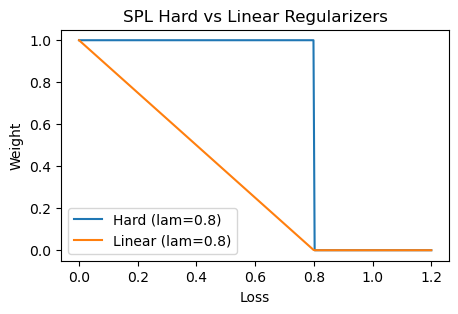

In [22]:
losses = torch.linspace(0, 1.2, 300)
lam = 0.8

plt.figure(figsize=(5, 3))

hard_w = hard_regularizer(losses, lam)
linear_w = linear_regularizer(losses, lam)

plt.plot(losses, hard_w, label=f"Hard (lam={lam})")
plt.plot(losses, linear_w, label=f"Linear (lam={lam})")

plt.xlabel("Loss")
plt.ylabel("Weight")
plt.title("SPL Hard vs Linear Regularizers")
plt.legend()
plt.show()

####  Training Scheduler

Losses are not limited to the range `(0,1]`, so a special scheduler that can go beyond this range must be defined.

In [23]:
def lambda_scheduler_linear(t, lam_0=0.2, lam_max=5.0, T=50):
    return min(lam_max, lam_0 + (lam_max - lam_0) * (t / T))

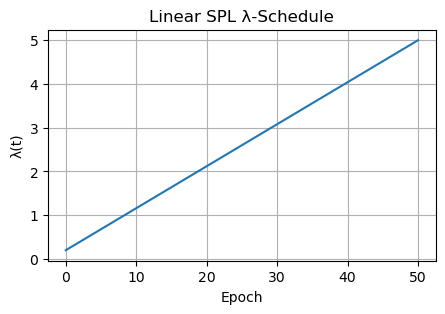

In [24]:
T = 50
ts = np.arange(0, T+1)

lams = [lambda_scheduler_linear(t, lam_0=0.2, lam_max=5.0, T=T) for t in ts]

plt.figure(figsize=(5,3))
plt.plot(ts, lams)
plt.title("Linear SPL λ-Schedule")
plt.xlabel("Epoch")
plt.ylabel("λ(t)")
plt.grid(True)
plt.show()

In [25]:
def calculate_loss(model, dataset, batch_size=128):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='none')

    all_losses = []
    with torch.no_grad():
        for x, y, _ in data_loader:
            x, y = x.to(device), y.to(device)
            losses = criterion(model(x), y).cpu()
            all_losses.append(losses)

    return torch.cat(all_losses)

In [49]:
def train_automatic_model(regularizer_fn, name=None):
    epochs = 50
    model = create_model()
    opt = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(reduction='none')  # per-sample loss

    val_accs = []
    best_val_acc = 0.0
    best_weights = None

    print(f"[{name}]")

    data_loader = DataLoader(train_set, batch_size=128, shuffle=True)


    epoch_nonzero = 0
    epoch_total = 0
    
    for t in range(epochs):

        lam = lambda_scheduler_linear(t, lam_0=0.5, lam_max=20.0, T=40)

        # TRAIN
        model.train()
        for x, y, _ in data_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)

            losses = criterion(preds, y)

            weights = regularizer_fn(losses, lam).to(device)

            weighted_loss = torch.mean(weights * losses)

            opt.zero_grad()
            weighted_loss.backward()
            opt.step()

        # VALIDATE
        model.eval()
        val_acc = evaluate(model, val_loader)
        val_accs.append(val_acc)
    
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = model.state_dict()

        epoch_nonzero += (weights > 0).sum().item()
        epoch_total += len(weights)

        nonzero_frac = epoch_nonzero / epoch_total
            
        print(f"\tEpoch {t+1}/{epochs} | Val Acc: {val_acc:.4f} | Lambda: {lam:.2f}")

    model.load_state_dict(best_weights)
    
    test_acc = evaluate(model, test_loader)
    print(f"\nTest Accuracy: {test_acc}")

    return model, val_accs, test_acc

In [50]:
automatic_hard_model, automatic_hard_val_accs, automatic_hard_test_acc = train_automatic_model(hard_regularizer,
                                                                                               name="Hard SPL CL")

[Hard SPL CL]
	Epoch 1/50 | Val Acc: 0.1270 | Lambda: 0.50
	Epoch 2/50 | Val Acc: 0.1330 | Lambda: 0.99
	Epoch 3/50 | Val Acc: 0.1490 | Lambda: 1.48
	Epoch 4/50 | Val Acc: 0.1430 | Lambda: 1.96
	Epoch 5/50 | Val Acc: 0.1460 | Lambda: 2.45
	Epoch 6/50 | Val Acc: 0.1530 | Lambda: 2.94
	Epoch 7/50 | Val Acc: 0.1470 | Lambda: 3.42
	Epoch 8/50 | Val Acc: 0.1510 | Lambda: 3.91
	Epoch 9/50 | Val Acc: 0.1500 | Lambda: 4.40
	Epoch 10/50 | Val Acc: 0.3950 | Lambda: 4.89
	Epoch 11/50 | Val Acc: 0.4820 | Lambda: 5.38
	Epoch 12/50 | Val Acc: 0.4900 | Lambda: 5.86
	Epoch 13/50 | Val Acc: 0.4740 | Lambda: 6.35
	Epoch 14/50 | Val Acc: 0.4990 | Lambda: 6.84
	Epoch 15/50 | Val Acc: 0.4930 | Lambda: 7.32
	Epoch 16/50 | Val Acc: 0.4740 | Lambda: 7.81
	Epoch 17/50 | Val Acc: 0.4660 | Lambda: 8.30
	Epoch 18/50 | Val Acc: 0.4840 | Lambda: 8.79
	Epoch 19/50 | Val Acc: 0.4880 | Lambda: 9.28
	Epoch 20/50 | Val Acc: 0.4890 | Lambda: 9.76
	Epoch 21/50 | Val Acc: 0.4710 | Lambda: 10.25
	Epoch 22/50 | Val Acc: 0.48

# Summary

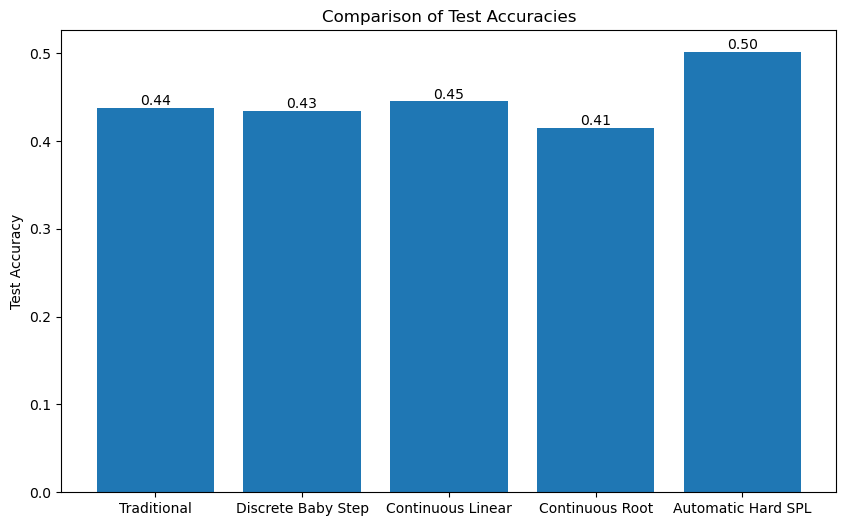

In [55]:
labels = [
    "Traditional",
    "Discrete Baby Step",
    "Continuous Linear",
    "Continuous Root",
    "Automatic Hard SPL"
]

values = [
    traditional_test_acc,
    babystep_test_acc,
    continuous_linear_test_acc,
    continuous_root_test_acc,
    automatic_hard_test_acc
]

fig, ax = plt.subplots(figsize=(10, 6))
bar_container = ax.bar(labels, values)

ax.set(
    ylabel='Test Accuracy',
    title='Comparison of Test Accuracies',
)

# Add labels on top of bars
ax.bar_label(bar_container, fmt='{:,.2f}')
plt.show()

## References:
<br>
Wang, X., Chen, Y., & Zhu, W. (2022). A Survey on Curriculum Learning. IEEE Transactions on Pattern Analysis and Machine Intelligence, 44(9), 4555–4576. https://doi.org/10.1109/TPAMI.2021.3069908
<br><br>
https://github.com/THUMNLab/CurML
<br>
https://zenodo.org/records/2535967